# Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_auc_score, recall_score, precision_score, f1_score
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, recall_score, precision_score, f1_score

In [4]:
df = pd.read_csv("datav1.csv").drop(columns=['Unnamed: 0', 'Player', 'year'])

# data preparation

In [5]:
# Step 2.1: Create binary classification target for Step 1
df['MVP_Candidate'] = (df['Share'] > .001).astype(int)

# Step 2.1: Classification split
X_classification = df.drop(columns=['Share', 'MVP_Candidate'])
y_classification = df['MVP_Candidate']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_classification, y_classification, test_size=0.2, stratify=y_classification, random_state=42
)

In [6]:
# Step 3.1: Define a neural network model
def create_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),  # Dropout to prevent overfitting
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 3.2: Convert training and test sets to NumPy arrays
X_train_nn = X_train_class.values
X_test_nn = X_test_class.values
y_train_nn = y_train_class.values
y_test_nn = y_test_class.values

In [7]:
# Step 3.3: Create the model
input_dim = X_train_nn.shape[1]

model = create_model(input_dim)
early_stopping = EarlyStopping(
    monitor='val_loss',
    #patience=0,
    restore_best_weights=True
)
history = model.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


/Users/arjunj/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8795 - loss: 0.3175 - val_accuracy: 0.9450 - val_loss: 0.1366
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9405 - loss: 0.1575 - val_accuracy: 0.9424 - val_loss: 0.1297
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9513 - loss: 0.1260 - val_accuracy: 0.9357 - val_loss: 0.1278
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9544 - loss: 0.1165 - val_accuracy: 0.9424 - val_loss: 0.1235
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9547 - loss: 0.1128 - val_accuracy: 0.9464 - val_loss: 0.1180
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9523 - loss: 0.1093 - val_accuracy: 0.9437 - val_loss: 0.1269


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       852
           1       0.67      0.86      0.75        80

    accuracy                           0.95       932
   macro avg       0.83      0.91      0.86       932
weighted avg       0.96      0.95      0.95       932

ROC-AUC: 0.9781
Recall: 0.8625
Precision: 0.6699
F1 Score: 0.7541


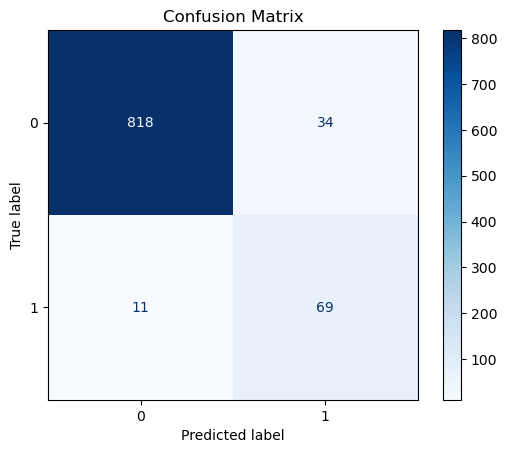

In [8]:
# Step 3.4 Evaluate the Model
# Predict probabilities and binary outcomes
y_pred_proba_nn = model.predict(X_test_nn).ravel()
y_pred_nn = (y_pred_proba_nn >= 0.3).astype(int)  # Adjust threshold for high recall

# Evaluate metrics
print("Classification Report:")
print(classification_report(y_test_nn, y_pred_nn))

roc_auc_nn = roc_auc_score(y_test_nn, y_pred_proba_nn)
recall_nn = recall_score(y_test_nn, y_pred_nn)
precision_nn = precision_score(y_test_nn, y_pred_nn)
f1_nn = f1_score(y_test_nn, y_pred_nn)

print(f"ROC-AUC: {roc_auc_nn:.4f}")
print(f"Recall: {recall_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"F1 Score: {f1_nn:.4f}")
# Generate the confusion matrix
cm = confusion_matrix(y_test_nn, y_pred_nn)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)

# Add title and labels
plt.title("Confusion Matrix")
plt.show()

In [9]:
# Step 3.5 Analyze the False Negatives
# Create a mask for false negatives
false_negative_mask = (y_test_nn == 1) & (y_pred_nn == 0)

# Extract the false negatives from the test dataset
false_negatives_df = X_test_class[false_negative_mask]

# Add the true labels and predicted probabilities to the DataFrame for context
false_negatives_df['True_Label'] = y_test_nn[false_negative_mask]
false_negatives_df['Predicted_Probability'] = y_pred_proba_nn[false_negative_mask]

print(false_negatives_df.head())
# Display the false negatives DataFrame
# Load the original data
datav1 = pd.read_csv("datav1.csv")

# Drop the columns "True_Label" and "Predicted_Probability" from false_negatives_df
columns_to_match = false_negatives_df.drop(columns=["True_Label", "Predicted_Probability"]).columns

# Filter rows from datav1 that match any row in false_negatives_df
matched_false_negatives = datav1[
    datav1.apply(
        lambda row: any(
            (false_negatives_df[columns_to_match] == row[columns_to_match].values).all(axis=1)
        ),
        axis=1
    )
]
# Display the resulting DataFrame
print("Matched False Negatives in datav1.csv:")
#matched_false_negatives.to_csv("matched_false_negatives.csv", index=False)
matched_false_negatives.head(len(matched_false_negatives))


             G        GS        MP        FG       FGA       FG%        3P  \
3159 -1.804628 -1.293099  0.404207  1.831291  2.180180 -0.933879 -0.725234   
383  -1.778555 -0.458199  1.041125  2.464337  2.643409 -0.406757 -0.454029   
1666  0.539951  0.784706  1.704801  1.939620  1.850140  0.252568  2.119591   
4503  0.855727  1.096734  0.643765  1.302167  0.717232  1.881566 -0.873544   
361  -0.323483  0.084580  0.364824 -0.214879 -0.585149  1.130742 -1.524359   

           3PA       3P%        2P  ...       OWS       DWS        WS  \
3159 -0.608660 -0.481748  2.239816  ... -0.839814 -0.327216 -0.824843   
383  -0.269375  0.039237  2.653385  ... -0.504596 -0.801773 -0.689416   
1666  1.512902  1.232970  1.047011  ...  2.324008 -0.981639  1.332632   
4503 -0.891131 -0.498825  1.587754  ...  1.490778  0.622622  1.407793   
361  -1.670077 -0.326201  0.604310  ... -0.019298  1.634385  0.500442   

         WS/48      OBPM      DBPM       BPM      VORP  True_Label  \
3159 -0.774399  0.9891

/var/folders/g9/3tj7x28j4hq3r0r9fqgmfcy80000gn/T/ipykernel_80297/1214625635.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives_df['True_Label'] = y_test_nn[false_negative_mask]
/var/folders/g9/3tj7x28j4hq3r0r9fqgmfcy80000gn/T/ipykernel_80297/1214625635.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives_df['Predicted_Probability'] = y_pred_proba_nn[false_negative_mask]


Matched False Negatives in datav1.csv:


,Unnamed: 0,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Share
361,361,Ben Simmons,-0.323483,0.084580,0.364824,-0.214879,-0.585149,1.130742,-1.524359,-1.670077,...,-0.310833,-0.019298,1.634385,0.500442,0.564304,-0.198417,1.699473,0.500375,0.415683,0.003
383,383,Bernard King,-1.778555,-0.458199,1.041125,2.464337,2.643409,-0.406757,-0.454029,-0.269375,...,2.832921,-0.504596,-0.801773,-0.689416,-0.775413,0.874528,-1.603994,0.114649,-0.045923,0.007
1666,1666,Glen Rice,0.539951,0.784706,1.704801,1.939620,1.850140,0.252568,2.119591,1.512902,...,1.250634,2.324008,-0.981639,1.332632,0.703859,1.331093,-1.817808,0.333886,0.624992,0.117
2030,2030,Jason Kidd,-1.059773,-0.364642,1.316023,-0.015903,0.300448,-1.200627,0.278065,0.444225,...,-0.109819,0.179966,1.734230,0.819926,0.835415,0.726728,1.539225,1.288990,1.234783,0.021
3159,3159,Michael Jordan,-1.804628,-1.293099,0.404207,1.831291,2.180180,-0.933879,-0.725234,-0.608660,...,2.811002,-0.839814,-0.327216,-0.824843,-0.774399,0.989192,-0.155809,0.839742,0.399953,0.013
3252,3252,Mitch Richmond,0.742129,1.065623,0.734836,1.159287,1.465686,-0.630059,2.464512,2.053279,...,1.396015,1.450115,-0.393373,0.996098,0.697637,1.366318,-0.486847,0.995402,1.177361,0.003
3651,3651,Ray Allen,0.564442,0.857008,1.286355,1.500503,1.767570,-0.724113,2.367195,2.321313,...,1.353244,2.389003,-1.116298,1.483120,1.021151,1.918712,-1.061129,1.205453,1.553552,0.032
3692,3692,Reggie Miller,0.748476,1.022280,0.384948,0.619618,0.490540,0.388790,2.209553,1.730128,...,0.665427,2.447366,0.123006,1.912478,1.687295,1.851088,-0.020137,1.506299,1.687344,0.002
4051,4051,Shawn Kemp,0.489489,0.662232,0.150423,0.724413,0.139607,2.062740,-0.808037,-0.894410,...,1.242694,0.683675,2.603753,1.575092,1.763838,0.341357,1.039146,0.733427,0.697531,0.065
4232,4232,Terry Porter,0.742632,0.939094,0.122766,0.069388,-0.079400,0.628005,2.759344,2.212238,...,-0.106262,2.012465,1.012518,1.956429,2.260602,1.967542,1.372947,2.178337,2.020967,0.026


In [10]:
# Step 3.5 Analyze the False Positives
# Create a mask for false positives
false_positive_mask = (y_test_nn == 0) & (y_pred_nn == 1)

# Extract the false positives from the test dataset
false_positives_df = X_test_class[false_positive_mask]

# Add the true labels and predicted probabilities to the DataFrame for context
false_positives_df['True_Label'] = y_test_nn[false_positive_mask]
false_positives_df['Predicted_Probability'] = y_pred_proba_nn[false_positive_mask]

print(false_positives_df.head())

# Load the original data
datav1 = pd.read_csv("datav1.csv")

# Drop the columns "True_Label" and "Predicted_Probability" from false_positives_df
columns_to_match = false_positives_df.drop(columns=["True_Label", "Predicted_Probability"]).columns

# Filter rows from datav1 that match any row in false_positives_df
matched_false_positives = datav1[
    datav1.apply(
        lambda row: any(
            (false_positives_df[columns_to_match] == row[columns_to_match].values).all(axis=1)
        ),
        axis=1
    )
]

# Display the resulting DataFrame
print("Matched False Positives in datav1.csv:")
matched_false_positives.to_csv("matched_false_positives.csv", index=False)


             G        GS        MP        FG       FGA       FG%        3P  \
4647  0.026466  0.502919  0.120889  1.283100  0.647380  1.232086 -1.675214   
2748  0.354948  0.734850  1.476616  1.451629  1.399245  0.058058  1.320307   
2440  0.703892  0.962092  0.676410  1.373717  0.897849  0.650861  0.378872   
647  -0.927329 -0.233646  0.686774  1.444998  1.807265 -0.638790  0.596048   
2433  0.712155  0.998042  0.701137  0.980462  0.910880  0.205593 -1.027153   

           3PA       3P%        2P  ...       OWS       DWS        WS  \
4647 -1.762960 -0.078168  2.143853  ...  0.685419  0.523744  0.725714   
2748  1.067519  0.796669  0.732952  ...  2.070277 -0.396691  1.543219   
2440  0.143782  0.665311  1.218051  ...  1.866055  1.019728  1.848116   
647   0.792159  0.517642  1.181685  ...  0.421740  0.511821  0.507183   
2433 -0.974154 -0.365548  1.443609  ...  1.198581  1.299687  1.480954   

         WS/48      OBPM      DBPM       BPM      VORP  True_Label  \
4647  0.850984  0.9109

/var/folders/g9/3tj7x28j4hq3r0r9fqgmfcy80000gn/T/ipykernel_80297/2444179426.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positives_df['True_Label'] = y_test_nn[false_positive_mask]
/var/folders/g9/3tj7x28j4hq3r0r9fqgmfcy80000gn/T/ipykernel_80297/2444179426.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positives_df['Predicted_Probability'] = y_pred_proba_nn[false_positive_mask]


Matched False Positives in datav1.csv:


In [11]:
# Step 3.5 Analyze the True Positives
# Create a mask for true positives
true_positive_mask = (y_test_nn == 1) & (y_pred_nn == 1)

# Extract the true positives from the test dataset
true_positives_df = X_test_class[true_positive_mask]

# Add the true labels and predicted probabilities to the DataFrame for context
true_positives_df['True_Label'] = y_test_nn[true_positive_mask]
true_positives_df['Predicted_Probability'] = y_pred_proba_nn[true_positive_mask]

print(true_positives_df.head())

# Load the original data
datav1 = pd.read_csv("datav1.csv")

# Drop the columns "True_Label" and "Predicted_Probability" from true_positives_df
columns_to_match = true_positives_df.drop(columns=["True_Label", "Predicted_Probability"]).columns

# Filter rows from datav1 that match any row in true_positives_df
matched_true_positives = datav1[
    datav1.apply(
        lambda row: any(
            (true_positives_df[columns_to_match] == row[columns_to_match].values).all(axis=1)
        ),
        axis=1
    )
]

# Display the resulting DataFrame
print("Matched True Positives in datav1.csv:")
matched_true_positives.to_csv("matched_true_positives.csv", index=False)


             G        GS        MP        FG       FGA       FG%        3P  \
3894  0.967611  1.158385  1.489141  2.136434  2.386449 -0.366124 -0.192193   
861   0.088486  0.574859  0.686267  1.044618  1.193790 -0.273786  1.475593   
4019  0.447219  0.693136  1.498712  3.299948  2.174106  2.860785 -0.953840   
237  -0.363436  0.155557  1.400683  2.458418  1.699582  1.281117 -1.108954   
1038  0.819739  1.123883  1.301446  1.211651  1.079095  0.438401 -0.749744   

           3PA       3P%        2P  ...       OWS       DWS        WS  \
3894  0.154989 -0.220054  2.326035  ...  1.003370  2.059025  1.531854   
861   1.598670  0.523941  0.444442  ...  1.878350  0.827983  1.794033   
4019 -0.993095 -1.520678  3.675543  ...  3.306876  3.435088  3.891149   
237  -1.102185 -1.470667  2.864334  ...  2.664465  1.661317  2.700815   
1038 -0.712965 -0.308471  1.499547  ...  1.353784  2.757408  2.232459   

         WS/48      OBPM      DBPM       BPM      VORP  True_Label  \
3894  0.849052  1.6249

/var/folders/g9/3tj7x28j4hq3r0r9fqgmfcy80000gn/T/ipykernel_80297/3177750166.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_positives_df['True_Label'] = y_test_nn[true_positive_mask]
/var/folders/g9/3tj7x28j4hq3r0r9fqgmfcy80000gn/T/ipykernel_80297/3177750166.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_positives_df['Predicted_Probability'] = y_pred_proba_nn[true_positive_mask]


Matched True Positives in datav1.csv:


# Data prep for regression model

In [12]:
df.columns

Index(['G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
       '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS',
       'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Share', 'MVP_Candidate'],
      dtype='object')

In [13]:
# Regression split (only for MVP candidates)
df_regression = df[df['MVP_Candidate'] == 1].copy()
X_regression = df_regression.drop(columns=['Share', 'MVP_Candidate'])
y_regression = df_regression['Share']

# Define a threshold to categorize high and low MVP share
threshold = 0.3

# Add a temporary stratification column to label high and low shares
df_regression.loc[:, 'Stratified_Label'] = (y_regression > threshold).astype(int)

# Perform stratified sampling
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression,
    y_regression,
    test_size=0.2,
    random_state=42,
    stratify=df_regression['Stratified_Label']
)

# Drop the temporary column from the dataset
df_regression = df_regression.drop(columns=['Stratified_Label'])

Testing alpha = 10.0
Testing alpha = 20.0
Testing alpha = 30.0
Testing alpha = 40.0
Testing alpha = 50.0
Testing alpha = 60.0
Testing alpha = 70.0
Testing alpha = 80.0
Testing alpha = 90.0
Testing alpha = 100.0
Best Alpha: 42.32
Best Mean Squared Error: 0.0358


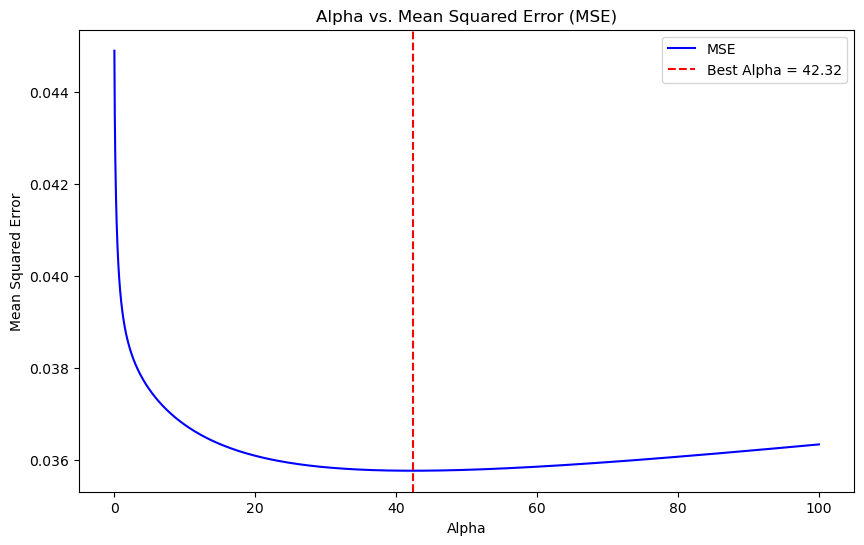

In [30]:
# Variables to track the best alpha and its corresponding MSE
bestAlpha = -1
bestMse = float('inf')

# Store alpha values and corresponding MSE for plotting
alpha_values = []
mse_values = []

# Search for the best alpha
for a in range(1, 10001):  # 0.01 to 100 in steps of 0.01
    alpha = a / 100  # Convert to decimal value
    if alpha % 10 == 0:
        print(f"Testing alpha = {alpha}")
    
    ridge_regressor = Ridge(alpha=alpha, random_state=42)
    ridge_regressor.fit(X_train_reg, y_train_reg)
    
    # Predict and evaluate
    y_pred_ridge = ridge_regressor.predict(X_test_reg)
    mse_ridge = mean_squared_error(y_test_reg, y_pred_ridge)
    
    # Track best alpha and MSE
    if mse_ridge < bestMse:
        bestMse = mse_ridge
        bestAlpha = alpha
    
    # Store alpha and MSE for plotting
    alpha_values.append(alpha)
    mse_values.append(mse_ridge)

# Print the best alpha and corresponding MSE
print(f"Best Alpha: {bestAlpha}")
print(f"Best Mean Squared Error: {bestMse:.4f}")

# Plot alpha vs. MSE
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, mse_values, color='blue', label="MSE")
plt.axvline(x=bestAlpha, color='red', linestyle='--', label=f"Best Alpha = {bestAlpha}")
plt.title("Alpha vs. Mean Squared Error (MSE)")
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()


In [35]:
ridge_regressor = Ridge(alpha=42.32, random_state=42)
ridge_regressor.fit(X_train_reg, y_train_reg)

# Predict and evaluate
y_pred_ridge = ridge_regressor.predict(X_test_reg)
mse_ridge = mean_squared_error(y_test_reg, y_pred_ridge)


# Step 1: Create a DataFrame from X_test_reg
test_results_df = X_test_reg.copy()  # Copy features

# Step 2: Add Actual Share (y_test_reg) and Predicted Share (y_pred_ridge)
test_results_df['Actual_Share'] = y_test_reg.values  # Add actual Share values
test_results_df['Predicted_Share'] = y_pred_ridge  # Add predicted Share values

# Step 3: Calculate the absolute error and add it as a new column
test_results_df['Error'] = abs(test_results_df['Actual_Share'] - test_results_df['Predicted_Share'])

# Step 4: Sort the DataFrame by Error (largest to smallest)
test_results_df = test_results_df.sort_values(by='Error', ascending=False)

# Step 5: Save the results to a CSV file
test_results_df.to_csv("ridge_regression_test_results.csv", index=False)

print("Test results saved to 'ridge_regression_test_results.csv'")


Test results saved to 'ridge_regression_test_results.csv'
